[![Open In Colab](./images/colab-badge.png)](https://colab.research.google.com/github/abrsvn/pyactr-book/blob/master/notebooks/25_posterior_beliefs_and_answering_the_theoretical_question.ipynb)

The code so far:

In [1]:
# uncomment the lines below to install the correct version of pymc3 and dependencies
# !pip3 install --upgrade 'arviz==0.11.1'
# !pip3 install --upgrade 'pymc3==3.9.3'

In [2]:
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import seaborn as sns

import pandas as pd
import pymc3 as pm

In [3]:
url = 'https://github.com/abrsvn/pyactr-book/blob/master/data/every_each.csv?raw=true'
every_each = pd.read_csv(url)
every_each["quant"] = every_each["quant"].astype('category')
every_each.shape

(347, 2)

In [4]:
every_each["dummy_quant"] = (every_each["quant"]=="each").astype("int")

In [5]:
quant = np.array(every_each["dummy_quant"])
RTs = np.array(every_each["logRTresid"])

## Posterior beliefs: estimating the model parameters and answering the theoretical question

With the priors and likelihood in hand, we can finally ask ```pymc3``` to give us the posterior distributions for the quantities of interest, namely ```mean_every``` and ```mean_difference```.

We specify the full model as shown below:

In [6]:
every_each_model = pm.Model()

with every_each_model:
    # priors
    mean_every = pm.Normal('mean_every', mu=0, sd=10)
    mean_difference = pm.Normal('mean_difference', mu=0, sd=10)
    sigma = pm.HalfNormal('sigma', sd=10)
    # likelihood
    observed_RTs = pm.Normal('observed_RTs',
                   mu=mean_every + quant*mean_difference,
                   sd=sigma,
                   observed=RTs)

with every_each_model:
    trace = pm.sample(draws=5000, tune=50000, cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mean_difference, mean_every]


Sampling 4 chains for 50_000 tune and 5_000 draw iterations (200_000 + 20_000 draws total) took 37 seconds.
The acceptance probability does not match the target. It is 0.5714099997964891, but should be close to 0.8. Try to increase the number of tuning steps.


Our assumptions for this model - and for Bayesian models in general - fall into two classes:

- the assumptions we need to specify the priors
- the assumptions we need to specify the likelihood (how the data is generated)

We discuss them in turn.

The priors for our model are specified on lines 5-7 above.

- our prior for the mean RT for _every_ is very weak / low information, as already discussed
- our prior for the difference in RT between _each_ and _every_ is similarly weak / low information
- finally, the prior for our noise distribution on line 6 allows for values anywhere between $0$ and $30$; this is a very non-committal range since the standard deviation of log RT residuals is at most 1, generating a range of log RT residuals between $-3$ and $3$ if these RTs are centered around $0$ and normally distributed

The likelihood (the data generation part of the model) is specified on lines 9-12 above.

- we indicate that we model the observed data by explicitly indicating on line 12 that these values are observed, and providing the variable that stores these observed values
- in this case, the observed values are stored in the variable ```RTs```, which we introduced before

- on line 10 of our model specification, we say that each RT is somewhere near the mean RT for the corresponding quantifier
    - if the RT is associated with the quantifier _every_, our dummy variable ```quant``` takes the value $0$, so line 10 reduces to ```mu = mean_every```
    - if the RT is associated with the quantifier _each_, the dummy variable ```quant``` takes the value $1$, so line 10 reduces to ```mu = mean_every + mean_difference```, that is, the mean RT for _each_
    
- as we already discussed, each RT is an imperfect, noisy reflection of the mean RT for the corresponding quantifier, so we add some normally distributed noise to that mean RT to obtain the actual RT
- this normal distribution for the noise has a standard deviation ```sigma``` (line 11)
- we do not know how large the noise is, so this will be the third parameter we estimate from the data

At the end of the day, our assumptions about the priors and the likelihood lead us to using two types of probability distributions:

- normal distributions, which come with two parameters / `knobs' (the mean and the standard deviation) that we can tweak to rearrange the way the probability mass is spread over the entire real line
- half-normal distributions, which are by default assumed to cover the entire positive part of the real line, and which come with only one parameter / `knob' (the standard deviation) that can be dialed in to manipulate the spread of probability mass over the positive real numbers

To summarize, we have three parameters we want to learn about from the data:

- the mean RT for _every_ (```mean_every```)
- the mean difference in RT between _each_ and _every_ (```mean_difference```)
- the magnitude of the noise / dispersion of the actual RTs around the mean RT for the corresponding quantifier (```sigma```)

All these three parameters contribute in essential ways to the likelihood, i.e., to the way we think the observed RTs data was generated (lines 9-12 in ```every-each-model```).

And we need prior distributions for each of these three parameters (lines 5-7 in ```every-each-model```) so that we have can update them with our observed RT data.

- these prior distributions have a total of five hyperparameters / `knobs' (two means and three standard deviations) that we need to set, and we have set them all at values that are very non-committal
- this is why we called them weak, low information priors

On lines 14-15 above, we finally run the model.

- this means that we ask ```pymc3``` to compute for us the posterior distributions for the two quantities that are of primary interest to us, namely ```mean_every``` and ```mean_difference```

We can now plot the resulting posterior distributions.

- the posterior distributions below are much more constrained than the very 'loose' prior distributions we specified, which indicates that we learned a lot from the data
- that is, these posterior distributions mostly reflect the data and not our priors (which were very weak)

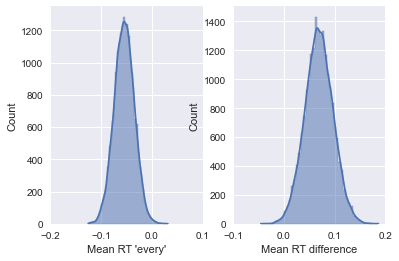

In [7]:
fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1)
fig.set_size_inches(6, 4)
plot1 = sns.histplot(trace['mean_every'], kde=True, bins=50,
                     element='step', ax=ax1)
plot1.set_xlim(-0.2, 0.1)
ax1.set_xlabel(r"Mean RT 'every'")
plot2 = sns.histplot(trace['mean_difference'], kde=True,
                     element='step', bins=50, ax=ax2)
plot2.set_xlim(-0.1, 0.2)
ax2.set_xlabel(r'Mean RT difference');

We can also compute the means and standard deviations (a.k.a. standard errors) of these posterior distributions:

In [8]:
mean_every = trace['mean_every']
mean_every.mean().round(2), mean_every.std().round(2)

(-0.05, 0.02)

In [9]:
mean_difference = trace['mean_difference']
mean_difference.mean().round(2), mean_difference.std().round(2)

(0.07, 0.03)

We see that the difference between _each_ and _every_ is positive, and significantly different from $0$ (most of the probability mass in the second plot above is to the right of $0$).

This provides evidence for Tunstall's hypothesis that _each_ contributes an event-differentiation requirement. Recall how we started our discussion of this dataset:

- if _each_ contributes an event-differentiation requirement, but not _every_, we expect it to have a higher preference for inverse scope than _every_
- and since inverse scope is known to lead to processing difficulties, which manifest themselves as increased reading times (RTs), we expect to see higher RTs for the _each_ sentence relative to _every_

## Conclusion

Bayesian methods for data analysis and cognitive modeling have two advantages, one theoretical and one computational.

- the theoretical one is that Bayesian methods are very intuitive:
    - they mathematically encode the common-sense idea that we have beliefs about what is plausible and (un)likely to happen in the world, and that we learn from experience
    - that is, experience / data updates these prior beliefs
- to do statistical inference or predictions boils down to computing posterior beliefs (i.e., prior beliefs updated with data) and examining these posterior beliefs in various ways.

Computationally, Bayesian methods in general and ```pymc3``` in particular give us access to a very powerful and flexible way of empirically evaluating linguistic theories.

- these theories can be faithfully and fairly directly encoded in specific structures for the priors and for the way we think the data is generated (the likelihood)
- we are not required to take our independently motivated linguistic theories and force them (or parts of them) into a pre-specified statistical inference mold
- the opposite actually happens: we take our theory in all its complex and articulated glory and embed it in a fairly direct fashion in a Bayesian model
- this in turn enables us to empirically evaluate it and do statistical inference about the parameters of the theory in a straightforward way

Being able to take mathematically specified cognitive models and embed them in a Bayesian model to empirically evaluate them will become essential in the next notebooks, when we start introducing the subsymbolic components of ACT-R

- the subsymbolic components of ACT-R come with a good number of real-valued parameters / 'knobs', and the Bayesian inference framework introduced in this chapter will enable us to learn the best settings for these parameters from the data rather than relying on default values that seem to be pulled out of thin air

- equally importantly, embedding rich cognitive theories in Bayesian models also enables us to do empirically-driven theory comparison
    - we can take two competing theories for the same phenomenon, collect experimental data, identify the best parameter settings for the two theories as well as our uncertainty about these parameter settings, and then compare how well the predictions made by these parameters settings fit the data
    
- we will in fact do this very soon, where we compare an exponential and a power-law model of forgetting